In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)


In [45]:
import hashlib
import re
from typing import Tuple

from src.debate.types import DebateScenario


def get_id(text: str) -> str:
    """Get the unique ID for the scenario."""
    return hashlib.md5(text.encode()).hexdigest()


def split_question(example: str) -> Tuple[str, str]:
    """Split the example text into the game and the question."""
    example_text = example
    question = re.split(r"\.\s+", example_text)[-1]
    game = example_text.replace(question, "").strip()
    return game, question


def convert_to_scenarios(examples: list) -> list[DebateScenario]:
    """Convert BoardgameQA examples to DebateScenario objects."""

    scenarios = []
    for ex in examples:
        situation, question = split_question(ex["example"])
        scenario = DebateScenario(
            id=get_id(ex["example"]),
            situation=situation,
            question=question,
            answer_options=["proved", "disproved", "unknown"],
            label=ex["label"],
            level=ex["level"],
        )
        scenarios.append(scenario)
    return scenarios

# Open the list of data

In [57]:
import json
from typing import Dict

LEVELS = ["LowConflict", "HighConflict"]
scenarios: Dict[str, DebateScenario] = {}
scenario_list = []

with open("../data/sampled_boardgame_qa.jsonl") as f:
    for line in f.readlines():
        data = json.loads(line)
        if data["level"] in LEVELS:
            scenario = convert_to_scenarios([data])
            scenarios[scenario[0].id] = scenario[0]
            scenario_list.append(scenario[0])

print(f"Number of scenarios: {len(scenarios)}")

Number of scenarios: 120


# Open the records

In [31]:
from pathlib import Path

result_path = Path("../results/self-play-claude-3.5-haiku")
baseline_batch_path = sorted(result_path.glob("baseline_*.json"))
debates_batch_path = sorted(result_path.glob("debates_*.json"))
judgements_batch_path = sorted(result_path.glob("judgments_*.json"))

print("Number of batch:")
print(f"  - baselines: {len(baseline_batch_path)}")
print(f"  - debates: {len(debates_batch_path)}")
print(f"  - judgements: {len(judgements_batch_path)}")

Number of batch:
  - baselines: 24
  - debates: 24
  - judgements: 24


In [106]:
from dotenv import load_dotenv

load_dotenv()

from langfuse import Langfuse

lf = Langfuse(
    host=os.getenv("LANGFUSE_HOST"),
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
)


def get_situation_question(text: str) -> str:
    """Split the example text into the game and the question."""
    situation = re.findall("<situation>(.*?)</situation>", text, re.DOTALL)[0].strip()
    question = re.findall("<question>(.*?)</question>", text, re.DOTALL)[0].strip()
    return f"{situation} {question}"


def get_scenario_id(baseline_dict: dict) -> str:
    """Get the scenario ID from the baseline dictionary."""
    traces = lf.fetch_traces(user_id=baseline_dict["id"]).data
    if traces:
        if observatio_ids := traces[0].observations:
            for observation_id in observatio_ids:
                observations = lf.fetch_observation(observation_id).data
                contents = [obs["content"] for obs in observations.input]
                sq = get_situation_question("\n".join(contents))
                scenario_id = get_id(sq)
                if scenario_id in scenarios:
                    return scenario_id

In [ ]:
MODEL_NAME = "claude-3.5-haiku"
scenario2record = {}  # key: scenario_id, value: list of record_id
baseline_records = {}  # key: scenario_id, value: list of baseline records
debate_records = {}  # key: record_id, value: debate record
judge_records = {}  # key: record_id, value: judgement record

baseline_count = 0
problematic_baseline = []

for i in range(len(baseline_batch_path)):
    with open(baseline_batch_path[i]) as f:
        baseline_ = json.load(f)
        baseline_ = list(baseline_.values())[0]
    with open(debates_batch_path[i]) as f:
        debates_ = json.load(f)
    with open(judgements_batch_path[i]) as f:
        judgements_ = json.load(f)
        judgements_ = list(judgements_.values())[0]

    print(f"\nBatch {i}")
    print(f"  - Number of baselines: {len(baseline_)}")
    print(f"  - Number of debates: {len(debates_)}")
    print(f"  - Number of judgements: {len(judgements_)}")

    scenario_this_batch = {}

    for debate in debates_:
        record_id = debate["id"]
        situation = debate["scenario"]["situation"]
        question = debate["scenario"]["question"]
        scenario_id = get_id(f"{situation} {question}")
        if scenario_id not in scenario2record:
            scenario2record[scenario_id] = []
        scenario2record[scenario_id].append(record_id)
        scenario = debate.pop("scenario")
        scenario_this_batch[scenario_id] = scenario

        debate.pop("id")
        debate_records[record_id] = debate

    for judgement in judgements_:
        record_id = judgement["id"]
        judgement.pop("id")
        judge_records[record_id] = judgement

    for baseline in baseline_:
        scenario_id = get_scenario_id(baseline)
        if scenario_id:
            baseline_records[scenario_id] = baseline
        else:
            print(f"Baseline {baseline['id']} not found")
            problematic_baseline.append(baseline)
            baseline_records[baseline["id"]] = baseline


print(f"Number of scenarios : {len(scenario2record)}")
print(f"Number of baselines : {len(baseline_records)}")
print(f"Number of debates   : {len(debate_records)}")
print(f"Number of judgements: {len(judge_records)}")
print(f"Number of problematic baselines: {len(problematic_baseline)}")


Batch 0
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15


Baseline 501c4796-c911-4b69-9486-9789d63db40a not found

Batch 1
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 7597301a-010c-478b-ae5d-bfc91b581d24 not found

Batch 2
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline ad786668-ecc0-46c0-81c9-e91546caaf72 not found

Batch 3
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 43133445-18e9-4b6d-b07b-7efcb923f6c6 not found

Batch 4
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 13a5d9b2-7c3f-46c7-a0e8-58c10ad99f5e not found
Baseline 91221e5f-b165-4eff-bda0-546c1b79e176 not found

Batch 5
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 265f7a60-5ef1-465e-b5a1-e7eb490d9531 not found

Batch 6
  - Number of baselines: 5
  - Number of debates: 15
  - Number of judgements: 15
Baseline 5921bb0c-a660-4cec-be4f-9be79a2b56e6 not found

Batch

In [59]:
record2scenario = {rec: sce for sce, recs in scenario2record.items() for rec in recs}
len(record2scenario)

360

In [124]:
# Get the line of the baseline judgement
for problem in problematic_baseline:
    print(problem["id"])
    print(problem["judgment"].split("\n")[4][2:])
    print()

501c4796-c911-4b69-9486-9789d63db40a
The bulldog is watching a movie from 1907

7597301a-010c-478b-ae5d-bfc91b581d24
The fangtooth is watching a movie from 1955

ad786668-ecc0-46c0-81c9-e91546caaf72
The dinosaur convinces the owl

43133445-18e9-4b6d-b07b-7efcb923f6c6
The songbird creates one castle for the rhino

13a5d9b2-7c3f-46c7-a0e8-58c10ad99f5e
The monkey (Max) has 90 dollars

91221e5f-b165-4eff-bda0-546c1b79e176
The wolf has a red card

265f7a60-5ef1-465e-b5a1-e7eb490d9531
The dove has 50 dollars

5921bb0c-a660-4cec-be4f-9be79a2b56e6
Chinchilla is named Lucy

bbe13940-8f48-45cf-83e0-49469f136dcc
Cobra is named Milo

6e0e30ff-d919-4987-9ef2-aebca4d13120
The pelikan has 74 dollars

5ae584ef-b1d8-4df5-b39f-f36a12b67d49
The elk swims in the pool next to the chinchilla's house

2e673cbb-2244-4cfe-88bf-b4921d7ec2cb
The bear is named Luna

1a2fca77-a40a-4e10-9d4a-fcbe9acab56f
The llama has an orange card

7c5461d9-a745-4a73-a6b0-625be652251c
The elk has a harmonica

d1e84ca0-06c3-4a89-b

In [153]:
# Sanity check
record_id = "3f793ccb-10e5-460e-bdd6-0856e95e4593"
record2scenario[record_id] not in baseline_records, record2scenario[record_id]

(True, 'eced42550a1f6fa49707c6e533fe0d44')

In [157]:
mapping = {
    "501c4796-c911-4b69-9486-9789d63db40a": "7dd4de9db2892178fa5ba47472c1f7a7",
    "7597301a-010c-478b-ae5d-bfc91b581d24": "c247d28bdedf9d10a7fdb548601c5c3f",
    "ad786668-ecc0-46c0-81c9-e91546caaf72": "2a3fd7fc41048b87ae847b1c2b213eaa",
    "43133445-18e9-4b6d-b07b-7efcb923f6c6": "51f04d6ac1cea47bf917fcea1d8cf3fd",
    "13a5d9b2-7c3f-46c7-a0e8-58c10ad99f5e": "915eb90d8c288df52e74c292fb9bef96",
    "91221e5f-b165-4eff-bda0-546c1b79e176": "bccc6fc66c08f1d61545c53acb8a20a7",
    "265f7a60-5ef1-465e-b5a1-e7eb490d9531": "cc30a2570cb8a12ccc629c3c3f94a6c3",
    "5921bb0c-a660-4cec-be4f-9be79a2b56e6": "bbefdeb0c4de615da9b165d2c160a818",
    "bbe13940-8f48-45cf-83e0-49469f136dcc": "da389cc894015ed6374554c62b334646",
    "6e0e30ff-d919-4987-9ef2-aebca4d13120": "16ac3e4888cba4553fc8aaaf002e1fb0",
    "5ae584ef-b1d8-4df5-b39f-f36a12b67d49": "d49c88a215021df70dafb455b0d8a49b",
    "2e673cbb-2244-4cfe-88bf-b4921d7ec2cb": "868248929d9028b28a3adb63271b484f",
    "1a2fca77-a40a-4e10-9d4a-fcbe9acab56f": "54b86326729f3697f5e9e4e2956aa867",
    "7c5461d9-a745-4a73-a6b0-625be652251c": "5a403b90860db9e409dcf80db7d2d3f2",
    "d1e84ca0-06c3-4a89-bd18-f8d057056f05": "a0bfb87225bc8b97730f23c978fbbc71",
    "84511c6b-a9a5-44d1-9398-f6df412161d8": "68fb90f6350de4b804c1c1dad37fe85e",
    "c5f06d36-cb31-4e20-92cf-bd8abdb9809a": "c5608d220836d96e64609d843f61f30c",
    "5a3f06c9-8072-4c15-ae0f-161b082602fc": "2d5795e57ded035e4358dbf645b410f2",
    "6c70266f-b43e-4e45-b963-36b3359cd059": "3ace07a009ef259c33ef3dacd82a2fcb",
    "3980d31e-b368-4c94-9938-6eb604dd39c8": "6cfda29cce95e99b8557b02a7329a2d7",
    "a4916c0b-74df-4783-808e-649190de6376": "09000c3d82cda08090f3527f6ace6ce4",
    "bb5a4af8-b279-42e2-a3f7-86e9818e10f8": "78771f21f888ff8325a1fa4d20a11898",
    "cb513a05-ba9b-41a1-bc64-1857a7c6f6e4": "7ca0a3144173fa83e8cf10035fd4c1bb",
    "15b8e1ce-a424-48cf-a4ec-b182ede0ee8c": "8eec006866fa99193f94453de6540673",
    "2104fb5f-c9a6-4913-ab5c-c5d530505d7c": "eced42550a1f6fa49707c6e533fe0d44",
}


# Replace the key in the baseline records with the correct scenario ID
copy_baseline_records = baseline_records.copy()
for key, value in copy_baseline_records.items():
    if key in mapping:
        baseline_records[mapping[key]] = value
        del baseline_records[key]
        print(f"Replace {key} with {mapping[key]}")

In [160]:
# Check if all the baseline records are in the scenario2record
for key in baseline_records.keys():
    if key not in scenario2record:
        print(f"{key} not in scenario2record")
    if key not in scenarios:
        print(f"{key} not in scenarios")

In [51]:
# Check if debates and judgements are consistent
for scenario_id in scenario2record:
    for record_id in scenario2record[scenario_id]:
        if record_id not in debate_records:
            print(f"Missing debate record: {record_id}")
        if record_id not in judge_records:
            print(f"Missing judgement record: {record_id}")

In [52]:
# Check if scenarios are consistent
for scenario_id in scenarios:
    if scenario_id not in scenario2record:
        print(f"Missing scenario: {scenario_id}")

# Extract judge model answers

In [171]:
!pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\Hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [230]:
from typing import Literal

import pandas as pd

from src.debate.types import DebaterNames, DebateRecord


def get_answer(text: str) -> Literal["A", "B", "C"]:
    """Get the answer from the text."""
    answer = re.findall(r"Answer: (A|B|C)", text)
    if answer:
        return answer[0]
    answer = re.findall(r"Answer: <(A|B|C)>", text)
    if answer:
        return answer[0]
    return "invalid"


def answer_to_label(answer: Literal["A", "B", "C"]) -> str:
    """Convert the answer to label."""
    if answer == "A":
        return "proved"
    elif answer == "B":
        return "disproved"
    elif answer == "C":
        return "unknown"
    return "invalid"


def get_num_correct_quote(text: str) -> int:
    """Get the number of correct quote from the text."""
    pattern = re.compile(r"<v_quote>(.*?)</v_quote>")
    return len(re.findall(pattern, text))

def get_num_incorrect_quote(text: str) -> int:
    """Get the number of incorrect quote from the text."""
    pattern = re.compile(r"<u_quote>(.*?)</u_quote>")
    return len(re.findall(pattern, text))

answers = []

for scenario_id, scenario in scenarios.items():
    baseline_judgement = baseline_records[scenario_id]["judgment"]
    baseline_answer = answer_to_label(get_answer(baseline_judgement))
    for record_id in scenario2record[scenario_id]:
        debate = DebateRecord(scenario=scenario, **debate_records[record_id])

        correct_debater_pos: Literal[1, 2, -1] = -1
        if debate.debater_positions[DebaterNames.A.value] == scenario.label:
            correct_debater_pos = 1
        elif debate.debater_positions[DebaterNames.B.value] == scenario.label:
            correct_debater_pos = 2

        # Get the number of validated quote from each debater argument
        debater_a_args = ""
        debater_b_args = ""
        for t in debate.transcript:
            if t["name"] == DebaterNames.A.value:
                debater_a_args += t["validated_response_arguments"]
            elif t["name"] == DebaterNames.B.value:
                debater_b_args += t["validated_response_arguments"]

        num_correct_quote_a = get_num_correct_quote(debater_a_args)
        num_correct_quote_b = get_num_correct_quote(debater_b_args)
        num_incorrect_quote_a = get_num_incorrect_quote(debater_a_args)
        num_incorrect_quote_b = get_num_incorrect_quote(debater_b_args)
        debater_a_quote_acc = num_correct_quote_a / (num_correct_quote_a + num_incorrect_quote_a)
        debater_b_quote_acc = num_correct_quote_b / (num_correct_quote_b + num_incorrect_quote_b)

        # Get the judge answer
        judge_judgement = judge_records[record_id]["judgment"]
        judge_chosen_debater = get_answer(judge_judgement)
        if judge_chosen_debater == "invalid":
            print(f"Invalid answer for record {record_id}")
            print(judge_judgement)
            continue
        chosen_debater_name = getattr(DebaterNames, judge_chosen_debater)
        judge_answer = debate.debater_positions[chosen_debater_name.value]


        # Get the accuracy of the chosen debater
        chosen_debater_quote_acc = 0
        other_debater_quote_acc = 0
        if chosen_debater_name == DebaterNames.A:
            chosen_debater_quote_acc = debater_a_quote_acc
            other_debater_quote_acc = debater_b_quote_acc
        elif chosen_debater_name == DebaterNames.B:
            chosen_debater_quote_acc = debater_b_quote_acc
            other_debater_quote_acc = debater_a_quote_acc
        quote_acc_diff = chosen_debater_quote_acc - other_debater_quote_acc

        answers.append(
            {
                "scenario_id": scenario_id,
                "record_id": record_id,
                "level": scenario.level,
                "correct_debater_pos": correct_debater_pos,
                "label": scenario.label,
                "baseline": baseline_answer,
                "judge": judge_answer,
                "a_quote_acc": debater_a_quote_acc,
                "a_quote_num": (num_correct_quote_a + num_incorrect_quote_a),
                "b_quote_acc": debater_b_quote_acc,
                "b_quote_num": (num_correct_quote_b + num_incorrect_quote_b),
                "quote_acc_diff": quote_acc_diff,
            }
        )

answers_df = pd.DataFrame.from_dict(answers)
answers_df.sample(2)

,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,quote_acc_diff
56,3581a1dccca6b59d5189dce5f56bea24,d3192c2e-d1f6-4054-b201-c7c4a9d59b3b,LowConflict,-1,proved,unknown,disproved,0.833333,6,1.0,6,-0.166667
178,51f04d6ac1cea47bf917fcea1d8cf3fd,458535cd-c5a7-4391-931c-e6a1f5654aa8,LowConflict,2,unknown,unknown,unknown,1.000000,8,1.0,9,0.000000


In [ ]:
# Calculate accuracy

baseline_correct = (answers_df["baseline"] == answers_df["label"]).sum()
judge_correct = (answers_df["judge"] == answers_df["label"]).sum()
total = len(answers_df)

baseline_accuracy = baseline_correct / total
judge_accuracy = judge_correct / total

print(f"Baseline Accuracy: {baseline_accuracy:.2%}")
print(f"Judge Accuracy: {judge_accuracy:.2%}")

# Break down by level
level_results = answers_df.groupby("level").apply(
    lambda x: pd.Series(
        {
            "baseline_accuracy": (x["baseline"] == x["label"]).mean(),
            "judge_accuracy": (x["judge"] == x["label"]).mean(),
            "count": len(x),
        }
    )
)
print("\nAccuracy by level:")
print(level_results)

# Break down by correct debater position and level
correct_debater_results = answers_df.groupby(["level", "correct_debater_pos"]).apply(
    lambda x: pd.Series(
        {
            "baseline_accuracy": (x["baseline"] == x["label"]).mean(),
            "judge_accuracy": (x["judge"] == x["label"]).mean(),
            "count": len(x),
        }
    )
)
print("\nAccuracy by correct debater position and level:")
print(correct_debater_results)
print("Note: Position -1 means no debater is arguing for the correct label.")

# Break down by label and level
label_results = answers_df.groupby(["level", "label"]).apply(
    lambda x: pd.Series(
        {
            "baseline_accuracy": (x["baseline"] == x["label"]).mean(),
            "judge_accuracy": (x["judge"] == x["label"]).mean(),
            "count": len(x),
        }
    )
)
print("\nAccuracy by label and level:")
print(label_results)

# Break down by correct debater position, label and level
correct_debater_label_results = answers_df.groupby(
    ["level", "correct_debater_pos", "label"]
).apply(
    lambda x: pd.Series(
        {
            "baseline_accuracy": (x["baseline"] == x["label"]).mean(),
            "judge_accuracy": (x["judge"] == x["label"]).mean(),
            # 'count': len(x)
        }
    )
)
print("\nAccuracy by correct debater position, label and level:")
print(correct_debater_label_results)

Baseline Accuracy: 45.83%
Judge Accuracy: 39.44%

Accuracy by level:
              baseline_accuracy  judge_accuracy  count
level                                                 
HighConflict           0.383333        0.383333  180.0
LowConflict            0.533333        0.405556  180.0

Accuracy by correct debater position and level:
                                  baseline_accuracy  judge_accuracy  count
level        correct_debater_pos                                          
HighConflict -1                            0.383333        0.000000   60.0
              1                            0.383333        0.466667   60.0
              2                            0.383333        0.683333   60.0
LowConflict  -1                            0.533333        0.000000   60.0
              1                            0.533333        0.450000   60.0
              2                            0.533333        0.766667   60.0
Note: Position -1 means no debater is arguing for the correct 

C:\Users\Hp\AppData\Local\Temp\ipykernel_3420\4197136598.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  level_results = answers_df.groupby('level').apply(
C:\Users\Hp\AppData\Local\Temp\ipykernel_3420\4197136598.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correct_debater_results = answers_df.groupby(['level', 'correct_debater_pos']).apply(
C:\Users\Hp\AppData\Local\Temp\ipykernel_3420\4197136

All: Judge accuracy when its selected debater give:
 - more correct quotes than other: 37.80%
 - equal correct quotes as other : 40.56%
 - otherwise                     : 39.62%
t-statistic: 0.582
p-value: 0.561

LowConflict: Judge accuracy when its selected debater give:
 - more correct quotes than other: 44.44%
 - equal correct quotes as other : 38.83%
 - otherwise                     : 39.13%
t-statistic: 1.811
p-value: 0.072

HighConflict: Judge accuracy when its selected debater give:
 - more correct quotes than other: 32.88%
 - equal correct quotes as other : 42.86%
 - otherwise                     : 40.00%
t-statistic: -0.860
p-value: 0.391


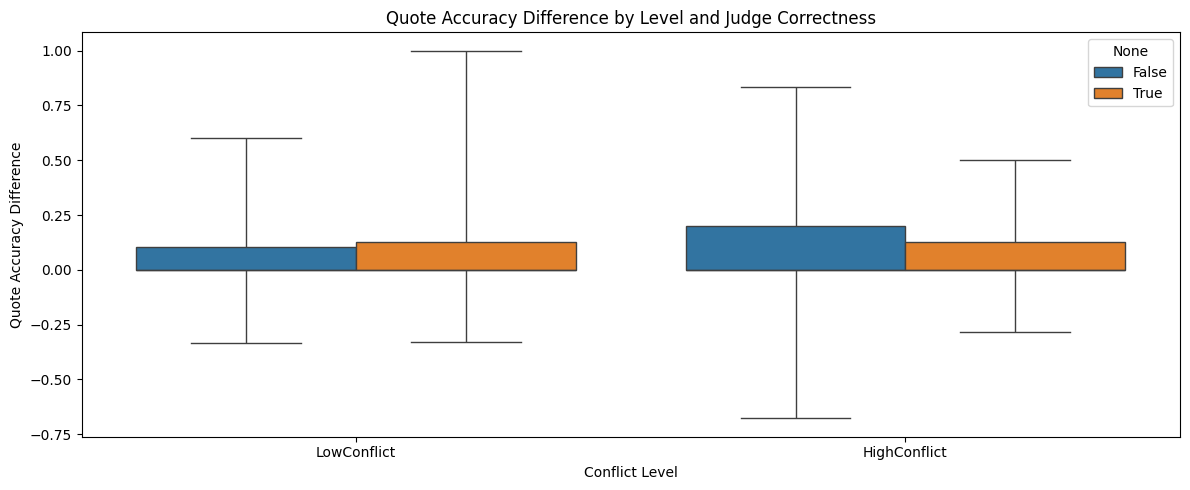

In [250]:
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

# Calculate average accuracy for positive and negative quote_acc_diff
pos_acc = answers_df[answers_df['quote_acc_diff'] > 0]['judge'] == answers_df[answers_df['quote_acc_diff'] > 0]['label']
eq_acc = answers_df[answers_df['quote_acc_diff'] == 0]['judge'] == answers_df[answers_df['quote_acc_diff'] == 0]['label']
neg_acc = answers_df[answers_df['quote_acc_diff'] < 0]['judge'] == answers_df[answers_df['quote_acc_diff'] < 0]['label']

print("All: Judge accuracy when its selected debater give:")
print(f" - more correct quotes than other: {pos_acc.mean():.2%}")
print(f" - equal correct quotes as other : {eq_acc.mean():.2%}")
print(f" - otherwise                     : {neg_acc.mean():.2%}")

# Perform t-test between quote_acc_diff for correct vs incorrect judgements
correct_diffs = answers_df[answers_df['judge'] == answers_df['label']]['quote_acc_diff']
incorrect_diffs = answers_df[answers_df['judge'] != answers_df['label']]['quote_acc_diff']
t_stat, p_value = stats.ttest_ind(correct_diffs, incorrect_diffs)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")


# Create a new figure with an additional subplot
plt.figure(figsize=(12, 5))

# Plot 3: Box plot of quote accuracy difference distribution by level and judge correctness
sns.boxplot(
    data=answers_df,
    x='level',
    y='quote_acc_diff',
    hue=answers_df['judge'] == answers_df['label'],
    whis=[0, 100],
)
plt.title('Quote Accuracy Difference by Level and Judge Correctness')
plt.xlabel('Conflict Level')
plt.ylabel('Quote Accuracy Difference')
# plt.legend(title='Judge Correct', labels=['No', 'Yes'])

plt.tight_layout()

# Calculate and print statistics by level
for level in answers_df['level'].unique():
    level_data = answers_df[answers_df['level'] == level]
    pos_acc = level_data[level_data['quote_acc_diff'] > 0]['judge'] == level_data[level_data['quote_acc_diff'] > 0]['label']
    eq_acc = level_data[level_data['quote_acc_diff'] == 0]['judge'] == level_data[level_data['quote_acc_diff'] == 0]['label']
    neg_acc = level_data[level_data['quote_acc_diff'] < 0]['judge'] == level_data[level_data['quote_acc_diff'] < 0]['label']

    print(f"\n{level}: Judge accuracy when its selected debater give:")
    print(f" - more correct quotes than other: {pos_acc.mean():.2%}")
    print(f" - equal correct quotes as other : {eq_acc.mean():.2%}")
    print(f" - otherwise                     : {neg_acc.mean():.2%}")

    # Perform t-test between quote_acc_diff for correct vs incorrect judgements
    correct_diffs = level_data[level_data['judge'] == level_data['label']]['quote_acc_diff']
    incorrect_diffs = level_data[level_data['judge'] != level_data['label']]['quote_acc_diff']
    t_stat, p_value = stats.ttest_ind(correct_diffs, incorrect_diffs)

    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.3f}")


In [ ]:
from scipy.stats import chi2_contingency

# Create quote accuracy bins, handling duplicate bin edges
answers_df['a_quote_acc_bin'] = pd.qcut(answers_df['a_quote_acc'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
answers_df['b_quote_acc_bin'] = pd.qcut(answers_df['b_quote_acc'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')

# Analyze judge accuracy by quote accuracy quartiles
print("Judge accuracy by Debater A quote accuracy quartiles:")
a_acc_results = answers_df.groupby('a_quote_acc_bin').apply(
    lambda x: pd.Series({
        'accuracy': (x['judge'] == x['label']).mean(),
        'count': len(x)
    })
)
print(a_acc_results)

print("\nJudge accuracy by Debater B quote accuracy quartiles:")
b_acc_results = answers_df.groupby('b_quote_acc_bin').apply(
    lambda x: pd.Series({
        'accuracy': (x['judge'] == x['label']).mean(),
        'count': len(x)
    })
)
print(b_acc_results)

# Chi-square test for independence

# Test for Debater A
contingency_a = pd.crosstab(answers_df['a_quote_acc_bin'], answers_df['judge'] == answers_df['label'])
chi2_a, p_value_a = chi2_contingency(contingency_a)[:2]
print("\nChi-square test for Debater A quote accuracy vs judge accuracy:")
print(f"Chi-square statistic: {chi2_a:.2f}")
print(f"p-value: {p_value_a:.6f}")

# Test for Debater B
contingency_b = pd.crosstab(answers_df['b_quote_acc_bin'], answers_df['judge'] == answers_df['label'])
chi2_b, p_value_b = chi2_contingency(contingency_b)[:2]
print("\nChi-square test for Debater B quote accuracy vs judge accuracy:")
print(f"Chi-square statistic: {chi2_b:.2f}")
print(f"p-value: {p_value_b:.6f}")

ValueError: Bin labels must be one fewer than the number of bin edges

In [218]:
from scipy import stats

# Statistical test for label bias
print("Testing for label bias:")

for level in answers_df["level"].unique():
    level_data = answers_df[answers_df["level"] == level]

    # Create contingency table for label vs judge accuracy
    contingency = pd.crosstab(
        level_data["label"], level_data["judge"] == level_data["label"]
    )

    # Perform chi-square test
    chi2, p_value = stats.chi2_contingency(contingency)[:2]

    print(f"\n{level}:")
    print("Contingency table:")
    print(contingency)
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value:.6f}")

# Statistical test for debater position bias
print("\nTesting for debater position bias:")

for level in answers_df["level"].unique():
    level_data = answers_df[answers_df["level"] == level]

    # Create contingency table for debater position vs judge accuracy
    contingency = pd.crosstab(
        level_data["correct_debater_pos"], level_data["judge"] == level_data["label"]
    )

    # Perform chi-square test
    chi2, p_value = stats.chi2_contingency(contingency)[:2]

    print(f"\n{level}:")
    print("Contingency table:")
    print(contingency)
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value:.6f}")

# Statistical test for debater position bias

Testing for label bias:

LowConflict:
Contingency table:
col_0      False  True 
label                  
disproved     32     28
proved        40     20
unknown       35     25
Chi-square statistic: 2.26
p-value: 0.323299

HighConflict:
Contingency table:
col_0      False  True 
label                  
disproved     32     28
proved        44     16
unknown       35     25
Chi-square statistic: 5.50
p-value: 0.063947

Testing for debater position bias:

LowConflict:
Contingency table:
col_0                False  True 
correct_debater_pos              
-1                      60      0
 1                      33     27
 2                      14     46
Chi-square statistic: 73.88
p-value: 0.000000

HighConflict:
Contingency table:
col_0                False  True 
correct_debater_pos              
-1                      60      0
 1                      32     28
 2                      19     41
Chi-square statistic: 61.90
p-value: 0.000000


In [217]:
# Statistical test for scenario level bias
print("\nTesting for scenario level bias:")
contingency = pd.crosstab(
    answers_df["level"], answers_df["judge"] == answers_df["label"]
)
# Perform chi-square test
chi2, p_value = stats.chi2_contingency(contingency)[:2]
print("Contingency table:")
print(contingency)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")


Testing for scenario level bias:
Contingency table:
col_0         False  True 
level                     
HighConflict    111     69
LowConflict     107     73
Chi-square statistic: 0.10
p-value: 0.7463
